In [11]:
import random
import numpy as np
import tensorflow as tf
import csv
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Bước 1: Đọc và xử lý dữ liệu gốc
raw_data = []
file_path = r"C:\Users\LOAN\Downloads\RPS\Rock_Paper_Scissors_Raw.csv"
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        raw_data.append(row)

game_data = []
current_game_id = None
current_game = []

for r in raw_data:
    if len(r) < 4:
        continue
    try:
        r2, r3 = int(r[2]), int(r[3])
    except ValueError:
        continue
    if r2 == 0 or r3 == 0:
        continue
    if current_game_id != r[0]:
        if current_game:
            game_data.append(current_game)
        current_game_id = r[0]
        current_game = []
    current_game.append((r2, r3))
if current_game:
    game_data.append(current_game)

In [4]:
# Bước 2: Sinh dữ liệu mô phỏng
game_data_simulated = []
r_move = lambda: random.choice((1, 2, 3))

for length, num_games in [(1, 1000), (2, 500), (3, 150), (4, 50)]:
    for moves in itertools.product((1, 2, 3), repeat=length):
        for _ in range(num_games):
            simulated_game = []
            for move in moves:
                simulated_game.extend((move, r_move()) for _ in range(random.randint(3, 20 - length)))
            game_data_simulated.append(simulated_game)

In [5]:
# Bước 3: One-hot encoding dữ liệu
def enc_game(game, invert=False):
    game_enc = [[0] * 6]
    for p1, p2 in game:
        if not (1 <= p1 <= 3 and 1 <= p2 <= 3):
            raise ValueError(f"Invalid moves: {p1}, {p2}")
        if invert:
            p1, p2 = p2, p1
        game_enc.append([0] * 6)
        game_enc[-1][p1 - 1] = 1
        game_enc[-1][p2 - 1 + 3] = 1
    return game_enc

game_data_one_hot = []
for game in game_data:
    for invert in (True, False):
        game_data_one_hot.append(enc_game(game, invert=invert))
for game in game_data_simulated:
    game_data_one_hot.append(enc_game(game))

In [6]:
# Bước 4: Chuẩn bị dữ liệu huấn luyện
X = [game[:-1] for game in game_data_one_hot]
Y = [[move[:3] for move in game[1:]] for game in game_data_one_hot]

X_np = [np.array(x).astype(np.float32) for x in X]
Y_np = [np.array(y).astype(np.float32) for y in Y]

# Padding dữ liệu
X_padded = pad_sequences(X_np, padding='post', dtype='float32')
Y_padded = pad_sequences(Y_np, padding='post', dtype='float32')

dataset = tf.data.Dataset.from_tensor_slices((X_padded, Y_padded))


In [7]:
# Bước 5: Tách tập dữ liệu
test_size = 2000
dev_size = 2000
dataset = dataset.shuffle(100000)
test_dataset = dataset.take(test_size)
dev_dataset = dataset.skip(test_size).take(dev_size)
train_dataset = dataset.skip(test_size + dev_size)

In [8]:
# Bước 6: Xây dựng mô hình RNN
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(128, input_shape=(None, 6), return_sequences=True),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\LOAN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Bước 7: Huấn luyện mô hình
batch_size = 32
history = model.fit(
    train_dataset.batch(batch_size),
    validation_data=dev_dataset.batch(batch_size),
    epochs=10
)

Epoch 1/10
5711/5711 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.9474 - loss: 0.0853 - val_accuracy: 0.9547 - val_loss: 0.0766
Epoch 2/10
5711/5711 ━━━━━━━━━━━━━━━━━━━━ 132s 23ms/step - accuracy: 0.9479 - loss: 0.0851 - val_accuracy: 0.9544 - val_loss: 0.0763
Epoch 3/10
5711/5711 ━━━━━━━━━━━━━━━━━━━━ 118s 21ms/step - accuracy: 0.9489 - loss: 0.0852 - val_accuracy: 0.9542 - val_loss: 0.0770
Epoch 4/10
5711/5711 ━━━━━━━━━━━━━━━━━━━━ 164s 29ms/step - accuracy: 0.9471 - loss: 0.0852 - val_accuracy: 0.9549 - val_loss: 0.0759
Epoch 5/10
5711/5711 ━━━━━━━━━━━━━━━━━━━━ 162s 28ms/step - accuracy: 0.9483 - loss: 0.0854 - val_accuracy: 0.9545 - val_loss: 0.0763
Epoch 6/10
5711/5711 ━━━━━━━━━━━━━━━━━━━━ 163s 28ms/step - accuracy: 0.9495 - loss: 0.0849 - val_accuracy: 0.9542 - val_loss: 0.0768
Epoch 7/10
5711/5711 ━━━━━━━━━━━━━━━━━━━━ 165s 29ms/step - accuracy: 0.9474 - loss: 0.0852 - val_accuracy: 0.9542 - val_loss: 0.0775
Epoch 8/10
5711/5711 ━━━━━━━━━━━━━━━━━━━━ 168s 29ms/step - accuracy: 0

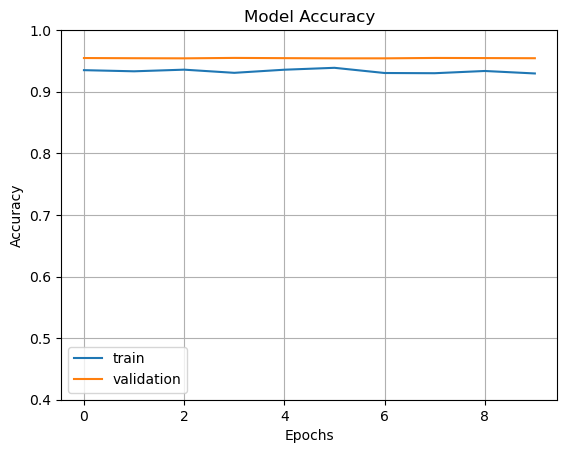

In [16]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0.4, 1)  # Đặt giới hạn cho trục y
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset.batch(batch_size))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9542 - loss: 0.0762
Test Loss: 0.07594112306833267, Test Accuracy: 0.9546054005622864


In [19]:
model.save(r"C:\Users\LOAN\Downloads\RPS\rps_rnn.h5")